## Aprendizaje por Refuerzo 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

### Trabajo Final

### 3º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |

## Double Deep Q-Learning Network aplicado a stock trading

### 1. DESCRIPCIÓN

Se presenta la implementación de un **AGENTE** entrenado mediante la técnica de Reinforced Learning Double Deep Q-Learning Network (DDQP) para la toma de decisiones aplicada a trading de acciones.

El entorno se ha generado en forma personalizada usando la librería Gymnasium

### 2. IMPLEMENTACIÓN

#### 2.1 LIBRERÍAS

In [1]:
import gymnasium as gym
import gymnasium.utils.seeding as seeding
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

#### 2.2 DATA

Se toma como caso testigo la acción de APPLE. Se aplica la API de Yahoo Finances para obtener los datos intradiarios de los últimos 10 años.

In [2]:
TICKET = 'AAPL'  # Apple Inc.

# Descargar datos
data = yf.download(TICKET, start='2015-01-01', end='2025-08-19')

C:\Users\Braian\AppData\Local\Temp\ipykernel_20420\3104949967.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKET, start='2015-01-01', end='2025-08-19')
[*********************100%***********************]  1 of 1 completed


In [3]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-08-12,229.649994,230.800003,227.070007,228.009995,55626200
2025-08-13,233.330002,235.000000,230.429993,231.070007,69878500
2025-08-14,232.779999,235.119995,230.850006,234.059998,51916300
2025-08-15,231.589996,234.279999,229.339996,234.000000,56038700
2025-08-18,230.889999,233.119995,230.110001,231.699997,37476200


Se divide el set en train/test usando una relación 80/20, respectivamente. Dado que se trata de una serie de tiempo, se respeta la cronología de datos en la división del set asegurando que el agente se evalúe en datos "futuros" no vistos durante el entrenamiento.

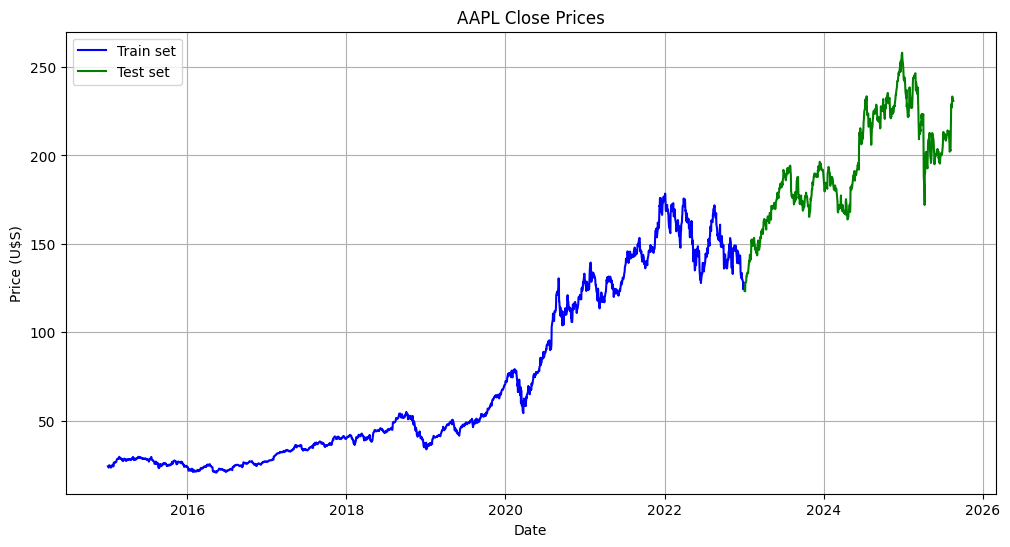

In [4]:
# Dividir en entrenamiento y prueba

split_date = '2023-01-01'  # Fecha de corte para entrenamiento/prueba

train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]
train_prices = train_data['Close'].values
test_prices = test_data['Close'].values

# Gráficos de los datos (combinados en uno solo)
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_prices, label='Train set', color='blue')
plt.plot(test_data.index, test_prices, label='Test set', color='green')
plt.title(f'{TICKET} Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (U$S)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# DEFINIMOS ALGUNAS FUNCIONES AUXILIARES PARA ANÁLISIS TÉCNICO

# Función para calcular RSI
def calculate_rsi(prices, period=14):
    if len(prices) < period + 1:
        return 50.0  # Neutral si no hay suficientes datos
    deltas = np.diff(prices)
    gains = deltas.copy()
    losses = deltas.copy()
    gains[gains < 0] = 0
    losses[losses > 0] = 0
    avg_gain = np.mean(gains[-period:])
    avg_loss = np.abs(np.mean(losses[-period:]))
    if avg_loss == 0:
        return 100.0
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Función para calcular EMA
def calculate_ema(prices, period=14):
    if len(prices) < period:
        return 0.0
    prices_window = prices[-period:]
    alpha = 2 / (period + 1)
    ema = prices_window[0]
    for price in prices_window[1:]:
        ema = alpha * price + (1 - alpha) * ema
    return ema

# Función para calcular SMA
def calculate_sma(prices, period=14):
    return np.mean(prices[-period:]) if len(prices) >= period else 0.0

# Función para calcular la tasa de variación promedio del precio en un período
def calculate_avg_rate(prices, period=14):
    if len(prices) < period + 1:
        return 0.0
    prices_window = prices[-(period + 1):]
    # Calcular las variaciones
    rates = np.diff(prices_window)
    # Retornar la media de las tasas de variación
    return np.mean(rates)

#### 2.3 ENVIRONMENT SETUP

Se define una clase personalizada 'TradingEnv' que hereda de gym.Env. Los parámetros clave incluyen:

- Capital inicial: $10,000.
- Ventana de observación: 30 días de precios normalizados.
- Indicadores técnicos: Medias móviles simples (SMA5, SMA20), exponenciales (EMA5, EMA20) y RSI.
- Espacio de observación: Vector de longitud 37 (precios + 7 indicadores ), continuo e ilimitado.
- Espacio de acciones: Discreto con 3 opciones (0: hold, 1: buy, 2: sell).
- Operaciones: Cada buy/sell opera un porcentaje fijo (10%) del capital inicial, con penalizaciones por comisiones (0.1%) y spreads (0.5%).
- Recompensa: Diferencia en valor neto (balance + shares * precio actual), penalizando implícitamente trades frecuentes por costos.
- Reset y Step: Reinicia al capital inicial; avanza un paso por día, terminando al fin de la serie.

El estado se calcula en _get_obs, normalizando precios e indicadores para facilitar el aprendizaje de la red neuronal. Esto enriquece el input con tendencias (SMA/EMA), momentum (RSI) y posición financiera, permitiendo al agente capturar patrones de mercado.

In [6]:
class TradingEnv(gym.Env):
    def __init__(self, prices, window_size=30):
        self.prices = prices
        self.window_size = window_size                  # Tamaño de la ventana de observación

        self.initial_balance = 10_000.0                 # Balance inicial
        self.cap_by_op = 0.10                           # Fracción del capital a invertir por operación
        self.commission = 0.001                         # Comisión de inversión por operación y comisión
        self.spread = 0.005                             # Spread de compra/venta. Se divide mitad para compra y venta respecto del valor medio
        
        self.current_step = window_size                 # Setea el inicio en la ventana de observación
        self.balance = self.initial_balance     
        self.shares_held = 0                            # Acciones en posesión 
        self.action_space = gym.spaces.Discrete(3)      # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(window_size + 9,)) # Ventana de precios + indicadores técnicos
    
    def seed(self, seed=None):
        """
        Set the seed for reproducibility in Gymnasium.
        """
        self.np_random, seed1 = seeding.np_random(seed)
        return [seed1]
        
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        return self._get_obs()

    def step(self, action):
        current_price = self.prices[self.current_step][0]                   # Precio actual
        prev_price = self.prices[self.current_step - 1][0]                  # Precio día anterior
        prev_net_worth = self.balance + self.shares_held * prev_price       # Patrimonio neto previo = CAJA + ACCIONES AL DÍA ANTERIOR

        amount_to_trade = self.initial_balance * self.cap_by_op             # Cantidad de dinero a operar
        shares_to_trade = int((amount_to_trade / current_price).item())     # Cantidad de acciones a operar
        if action == 1:  # Buy
            buy_cost_factor = 1 + self.commission + 0.5 * self.spread
            total_buy_cost = shares_to_trade * current_price * buy_cost_factor
            if self.balance >= total_buy_cost:
                self.shares_held += shares_to_trade
                self.balance -= total_buy_cost
        elif action == 2 and self.shares_held > 0:  # Sell
            shares_to_sell = min(shares_to_trade, self.shares_held)  # No vender más de lo disponible
            sell_income_factor = 1 - self.commission - 0.5 * self.spread
            total_sell_income = shares_to_sell * current_price * sell_income_factor
            self.shares_held -= shares_to_sell
            self.balance += total_sell_income

        net_worth = self.balance + self.shares_held * current_price         # Patrimonio neto actual
        reward = net_worth - prev_net_worth                                 # Recompensa = Balance entre pasos

        self.current_step += 1                                              # Actualiza el paso
        done = self.current_step >= len(self.prices)
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        prices_window = self.prices[self.current_step - self.window_size:self.current_step].flatten()
        max_price = np.max(prices_window) if len(prices_window) > 0 and np.max(prices_window) != 0 else 1.0
        prices_window = prices_window / max_price
        # Calcular indicadores técnicos
        ema8 = calculate_ema(prices_window, period=8)           # Corto plazo
        ema21 = calculate_ema(prices_window, period=21)         # Corto plazo
        ema50 = calculate_ema(prices_window, period=50)         # Mediano plazo
        sma100 = calculate_sma(prices_window, period=100)       # Mediano plazo
        sma200 = calculate_sma(prices_window, period=200)       # Largo plazo
        window_rate = calculate_avg_rate(prices_window, period = self.window_size-1)  # Tasa de variación promedio en la ventana
        rsi = calculate_rsi(prices_window)
        position = np.array([self.balance / self.initial_balance, self.shares_held])
        indicators = np.array([ema8, ema21, ema50, sma100, sma200, window_rate, rsi, position[0], position[1]], dtype=np.float32)
        return np.concatenate((prices_window, indicators)).astype(np.float32)

#### 2.4 REINFORCED LEARNING MODEL

El agente se implementa en DDQNAgent, usando PyTorch:

Redes neuronales: Dos DQN (principal y objetivo), cada una con capas de 128-64-3 neuronas y activación ReLU.
Hiperparámetros: Gamma=0.99 (descuento), epsilon=1.0 decay a 0.01 (exploración), batch_size=64, memoria=10,000 experiencias.
Métodos clave:

act: Epsilon-greedy para seleccionar acción.
replay: Experience replay con minibatch; calcula Q objetivo usando target_model para estabilidad.
remember: Almacena transiciones.
Update target cada 10 episodios.



El entrenamiento ocurre en 1000 episodios, donde cada episodio recorre la serie de precios de entrenamiento, acumulando recompensas y actualizando la red vía Adam optimizer y MSE loss.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os

# Fijar seed para reproducibilidad
seed = 42  # Puedes cambiar este valor, pero manténlo fijo para repeticiones
os.environ['PYTHONHASHSEED'] = str(seed)  # Para hash consistency
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Si usas GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
buffer_size = 10_000  # Tamaño del buffer de memoria

# Red Neuronal Q
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Agente DDQN (Enfoque Double DQN con replay buffer, target network)
class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.batch_size = 64
        # Inicializar modelos
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # --- Método para actualizar la Red Objetivo --
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # --- Método para ejecutar una acción --
    def act(self, state):       # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)   # Exploración 
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state)
            return np.argmax(act_values.detach().numpy())

    # --- Replay Buffer ---
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        states = torch.FloatTensor(np.array(states))
        next_states = torch.FloatTensor(np.array(next_states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        Q_expected = self.model(states).gather(1, actions).squeeze()

        # --- INICIO DE LA MODIFICACIÓN DOUBLE DQN ---
        with torch.no_grad():
            # 1. Selecciona las acciones con la red principal u ONLINE
            next_actions = self.model(next_states).max(1)[1].unsqueeze(1)
            # 2. Calcula los valores Q de las acciones seleccionadas con la red TARGET
            Q_targets_next = self.target_model(next_states).gather(1, next_actions).squeeze()

        # --- FIN DE LA MODIFICACIÓN DOUBLE DQN ---

        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        loss = self.criterion(Q_expected, Q_targets.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


#### 2.5 TRAINING

Episodio 0 completado, Recompensa total: 5864.897153988002
Episodio 50 completado, Recompensa total: 4645.66435062802
Episodio 100 completado, Recompensa total: 7413.955414125561
Episodio 150 completado, Recompensa total: 6076.378639859309
Episodio 200 completado, Recompensa total: 1506.3369073296526
Episodio 250 completado, Recompensa total: 20973.509251317126
Episodio 300 completado, Recompensa total: 22689.710627998433
Episodio 350 completado, Recompensa total: -53.190492830224684
Episodio 400 completado, Recompensa total: 2032.7273768988198
Episodio 450 completado, Recompensa total: 1246.335874288592
Episodio 500 completado, Recompensa total: 1734.8837236833733
Episodio 550 completado, Recompensa total: 298.63583448983263
Episodio 600 completado, Recompensa total: -44.33013537597617
Episodio 650 completado, Recompensa total: -10.881065725325243
Episodio 700 completado, Recompensa total: 0.0
Episodio 750 completado, Recompensa total: 0.0
Episodio 800 completado, Recompensa total: 43

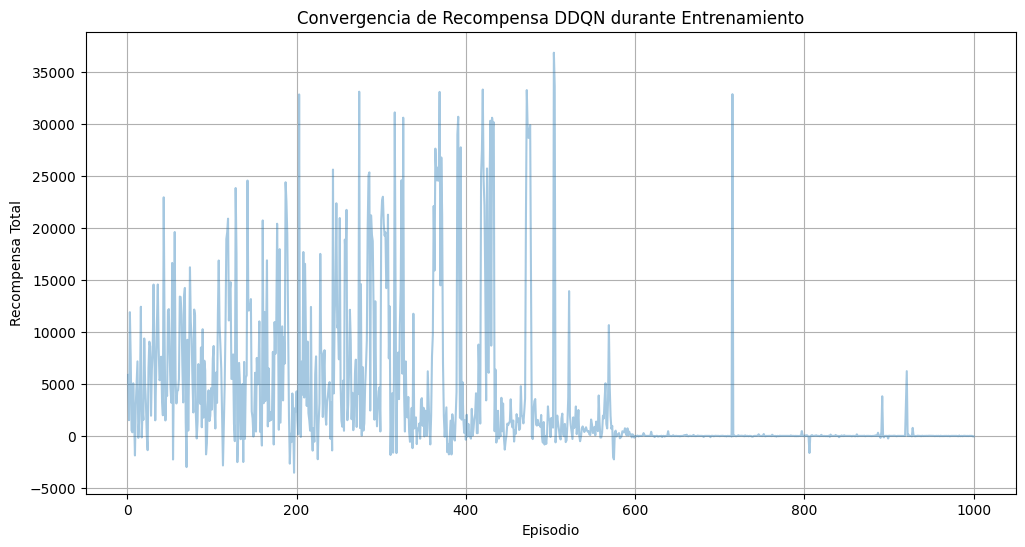

In [9]:
target_update_freq = 100  # Frecuencia de actualización del modelo objetivo
print_every = 50          # Frecuencia de impresión de recompensas

epsilon_start = 1.0
epsilon_end = 0.001
epsilon_decay_episodes = 600

# Entrenamiento (específico de DDQN: loop de episodios con el agente)
# --- Entorno ---
env = TradingEnv(train_prices)
env.seed(42)  # Fijar la semilla para reproducibilidad
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# --- Agente ---
agent = DDQNAgent(state_size, action_size)
agent.epsilon = epsilon_start  # Inicializar epsilon

# --- Entrenamiento del Agente ---
episodes = 1_000
episode_rewards = []
for e in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        agent.replay()
        total_reward += reward

    episode_rewards.append(total_reward)
    # Actualizar epsilon
    agent.epsilon = max(epsilon_end, epsilon_start - (e / epsilon_decay_episodes) * (epsilon_start - epsilon_end))
    if e % target_update_freq == 0:
        agent.update_target_model()
    if e % print_every == 0:
        print(f"Episodio {e} completado, Recompensa total: {total_reward}")


# --- Graficar Curva de Convergencia ---
print("\n--- Generando Gráfico de Convergencia ---")
plt.figure(figsize=(12, 6))
plt.plot(range(1, episodes + 1), episode_rewards, label='Recompensa por Episodio', alpha=0.4)
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.title("Convergencia de Recompensa DDQN durante Entrenamiento")
plt.grid(True)
plt.show()

Durante los 1000 episodios, las recompensas por episodio muestran una tendencia ascendente, estabilizándose alrededor de valores positivos tras 500 episodios. Esto indica convergencia: el agente aprende a maximizar ganancias evitando trades costosos. El decay de epsilon reduce la exploración, enfocando en explotación de la política aprendida.

In [15]:
def eval_agent(data, seed=42):

    prices = data['Close'].values
    test_env = TradingEnv(prices)
    test_env.seed(seed)  # Asegurar reproducibilidad en la prueba
    state = test_env.reset()
    done = False
    total_reward = 0
    net_worths = []
    actions_taken = []  # Para histograma de acciones
    shares_over_time = []  # Para gráfico de shares
    rewards_per_step = []  # Para gráfico de recompensas por paso
    cum_returns = []  # Para retornos acumulados

    while not done:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        act_values = agent.model(state_t)
        action = np.argmax(act_values.detach().numpy())
        next_state, reward, done, _ = test_env.step(action)
        state = next_state
        current_net = test_env.balance + test_env.shares_held * test_env.prices[test_env.current_step - 1]
        net_worths.append(current_net)
        actions_taken.append(action)
        shares_over_time.append(test_env.shares_held)
        rewards_per_step.append(reward)
        # Retorno acumulado (relativo al inicial)
        cum_return = (current_net - test_env.initial_balance) / test_env.initial_balance
        cum_returns.append(cum_return)
        total_reward += reward

    print(f"Recompensa total: {total_reward}")
    print(f"Valor neto final: {net_worths[-1]}")

    # Buy and Hold benchmark
    buy_price = test_env.prices[test_env.window_size]
    shares_bought = int(test_env.initial_balance / buy_price)
    residual = test_env.initial_balance - shares_bought * buy_price
    end_price = test_env.prices[-1]
    bh_net = residual + shares_bought * end_price
    print(f"Valor neto Buy and Hold: {bh_net}")

    # Benchmark retornos acumulados (para comparación)
    bh_cum_returns = []
    bh_net_worths = []
    bh_shares = test_env.initial_balance / test_env.prices[test_env.window_size]  # Fraccional para precisión
    for i in range(test_env.window_size, len(test_env.prices)):
        bh_net_worth = bh_shares * test_env.prices[i]
        bh_net_worths.append(bh_net_worth)
        bh_cum_return = (bh_net_worth - test_env.initial_balance) / test_env.initial_balance
        bh_cum_returns.append(bh_cum_return)

    # Gráficos (diferentes de interés)
    fig, axs = plt.subplots(2, 2, figsize=(18, 18))  # 2 filas, 2 columnas para múltiples gráficos
    test_dates = data.index[test_env.window_size:]
    
    # # 1. Valor neto en prueba vs. Buy and Hold

    # axs[0, 0].plot(test_dates[:len(net_worths)], net_worths, label='DDQN')
    # axs[0, 0].axhline(bh_net, color='r', linestyle='--', label='Buy and Hold')
    # axs[0, 0].set_title('Valor Neto en Prueba')
    # axs[0, 0].set_xlabel('Fecha')
    # axs[0, 0].set_ylabel('Valor Neto')
    # axs[0, 0].legend()
    # axs[0, 0].grid(True)

    # 1. Histograma de acciones tomadas
    axs[0, 0].hist(actions_taken, bins=[-0.5, 0.5, 1.5, 2.5], edgecolor='black')
    axs[0, 0].set_title('Histograma de Acciones Tomadas')
    axs[0, 0].set_xlabel('Acción (0: Hold, 1: Buy, 2: Sell)')
    axs[0, 0].set_ylabel('Frecuencia')
    axs[0, 0].set_xticks([0, 1, 2])
    axs[0, 0].grid(True)

    # 2. Shares en posesión vs. tiempo
    axs[0, 1].plot(test_dates[:len(shares_over_time)], shares_over_time)
    axs[0, 1].set_title('Shares en Posesión vs. Tiempo')
    axs[0, 1].set_xlabel('Fecha')
    axs[0, 1].set_ylabel('Número de Shares')
    axs[0, 1].grid(True)

    # 3. Recompensas por episodio
    axs[1, 0].plot(test_dates[:len(rewards_per_step)], rewards_per_step)
    axs[1, 0].set_title('Recompensas por Episodio')
    axs[1, 0].set_xlabel('Fecha')
    axs[1, 0].set_ylabel('Recompensa')
    axs[1, 0].grid(True)

    # 4. Retornos acumulados vs. Buy and Hold
    axs[1, 1].plot(test_dates[:len(cum_returns)], cum_returns, label='DDQN')
    axs[1, 1].plot(test_dates[:len(bh_cum_returns)], bh_cum_returns, label='Buy and Hold', linestyle='--')
    axs[1, 1].set_title('Retornos Acumulados por Fecha')
    axs[1, 1].set_xlabel('Fecha')
    axs[1, 1].set_ylabel('Retorno Acumulado')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return actions_taken, shares_over_time, rewards_per_step, cum_returns

Recompensa total: 0.0
Valor neto final: [10000.]
Valor neto Buy and Hold: [44975.31415367]


C:\Users\Braian\AppData\Local\Temp\ipykernel_20420\1202749474.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shares_bought = int(test_env.initial_balance / buy_price)


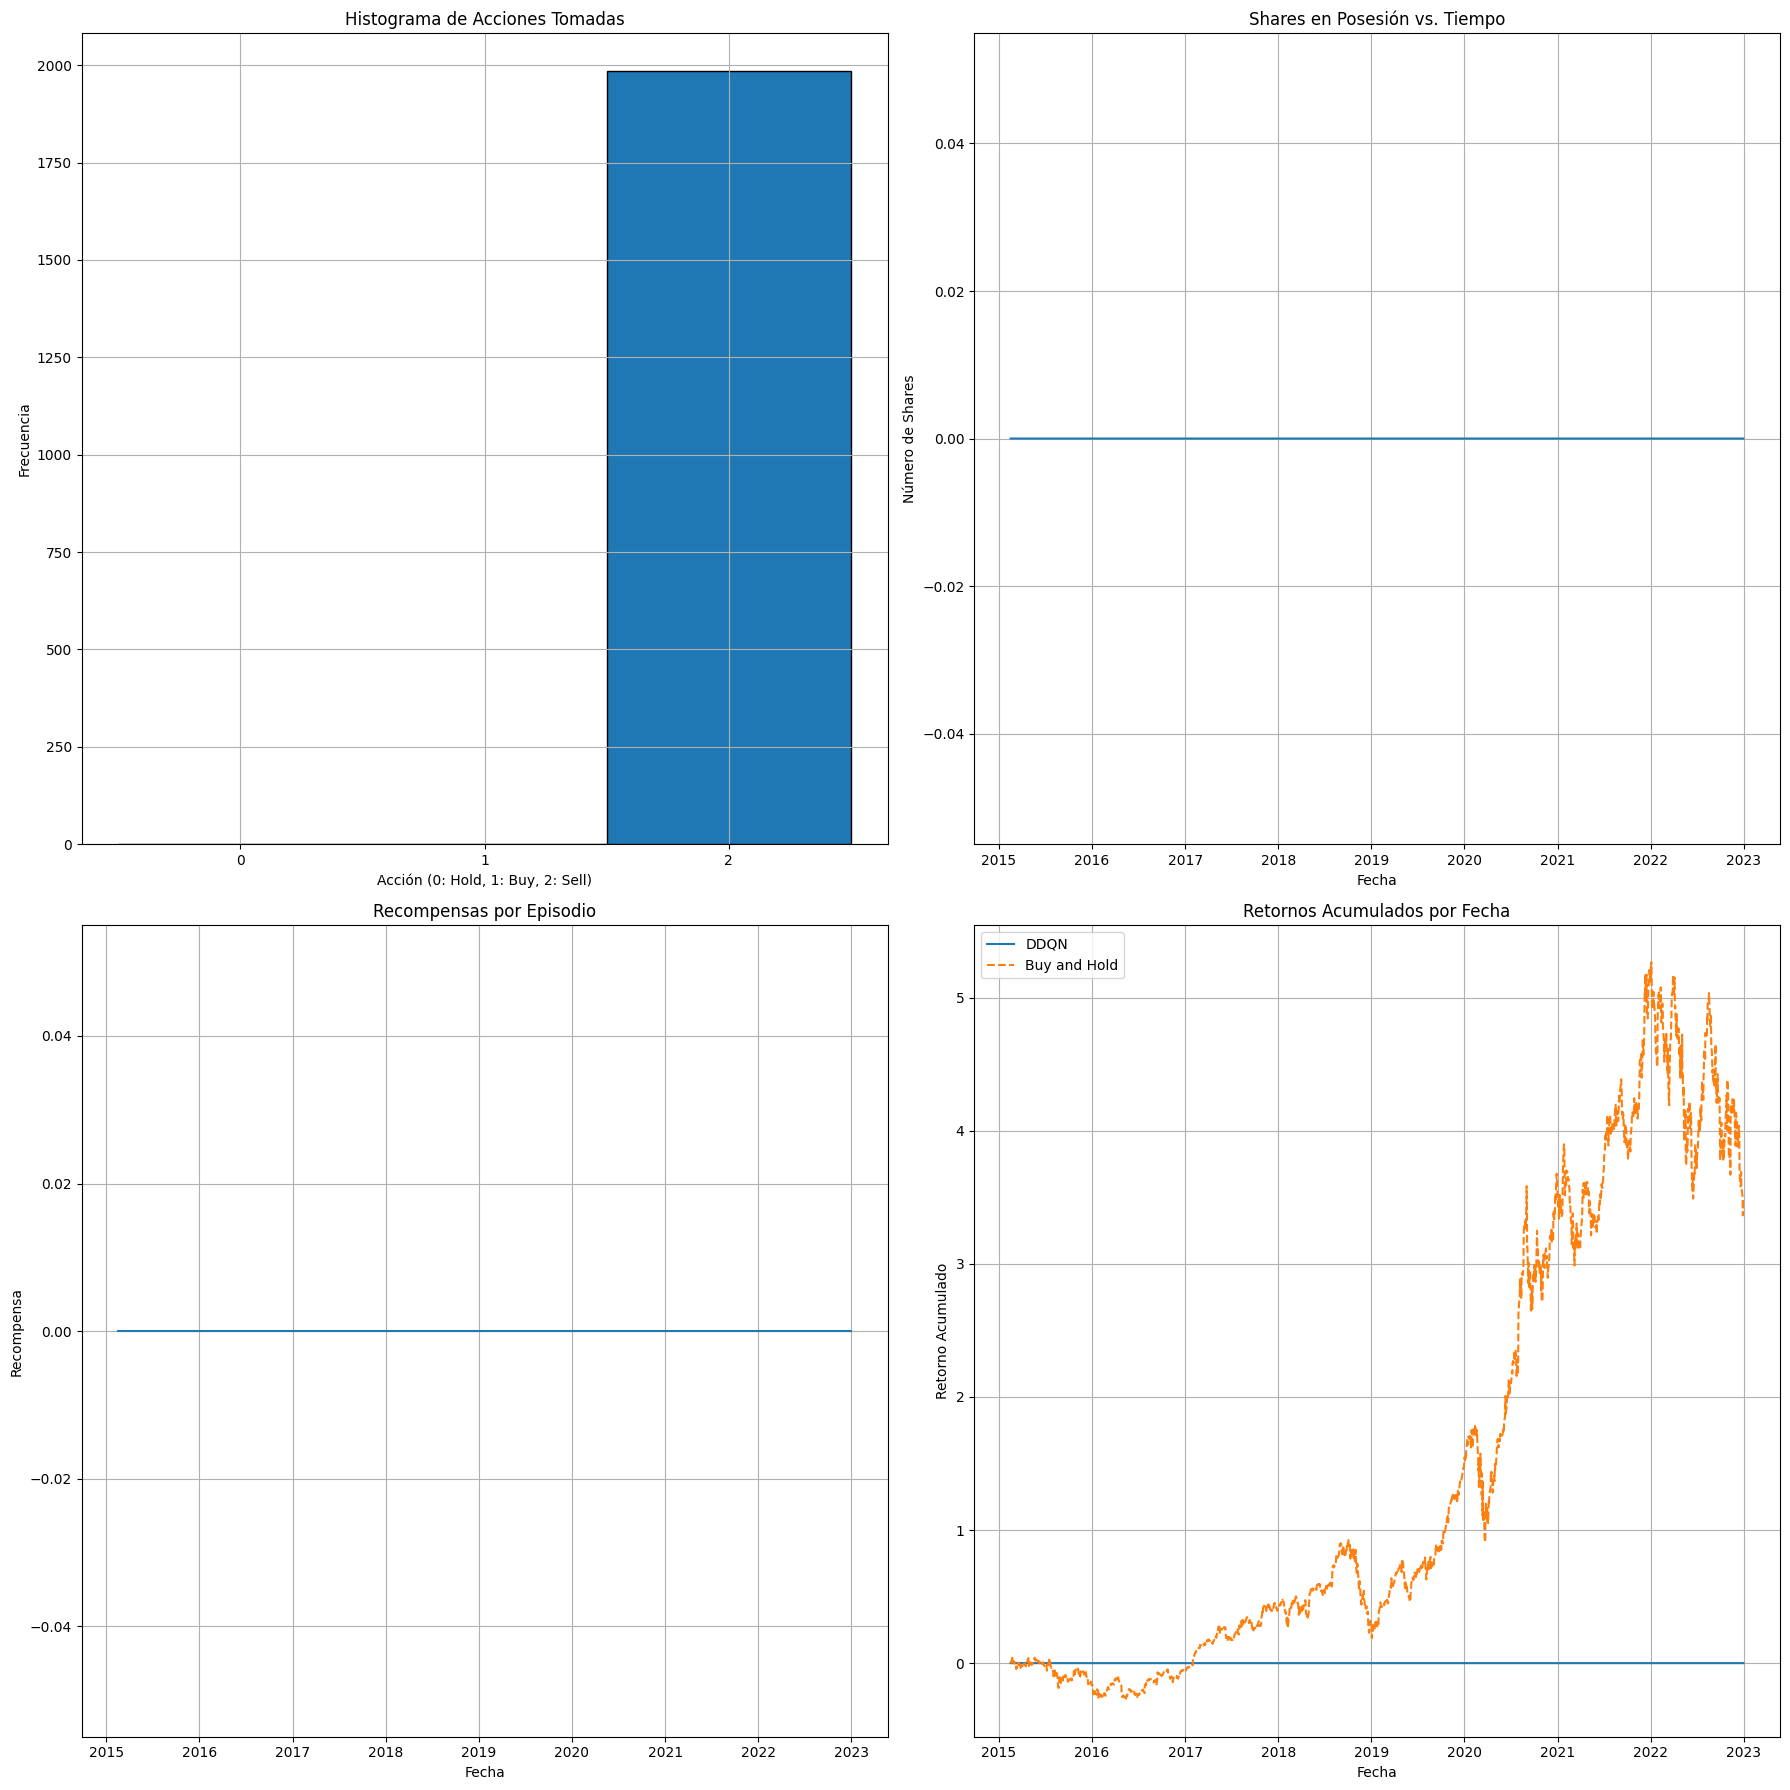

In [16]:
train_results = eval_agent(train_data)

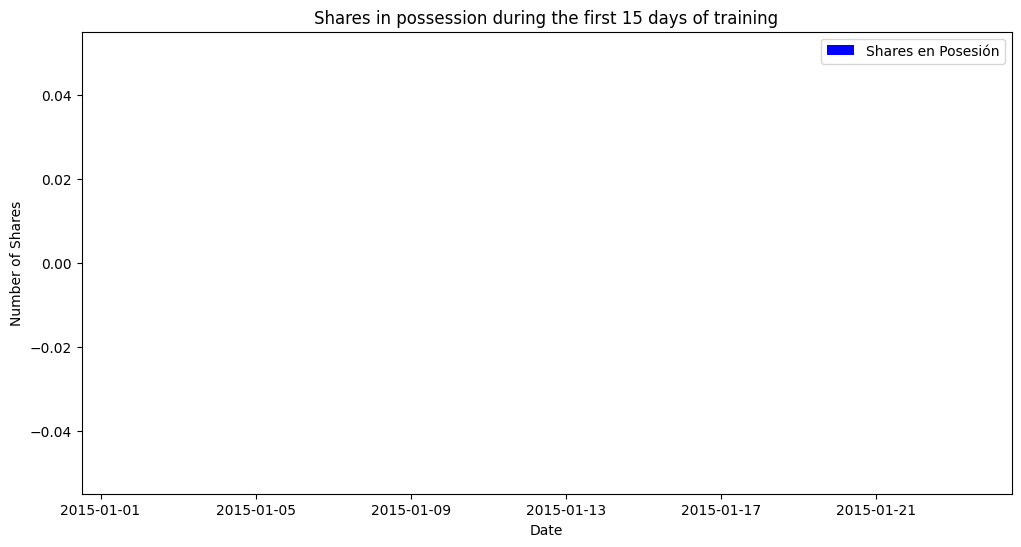

In [18]:
ndays = 15

plt.figure(figsize=(12, 6))
plt.bar(train_data.index[:ndays], train_results[1][:ndays], label='Shares en Posesión', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Shares')
plt.title(f'Shares in possession during the first {ndays} days of training')
plt.legend()
plt.show()

**OBSERVACIONES**:
- Vemos que la estrategia adoptada por el algoritmo fue básicamente compar y mantener, agotando el cupo diario hasta consumir todo el capital disponible para inversión.

- Está estrategia tiene lógica considerando que durante el período de entrenamiento se vio una gran apreciación de la acción tomada como benchmark y la estrategia de "buy and hold" evidentemente dio grandes frutos.

- Esto último también estuvo motivado por el hecho de que, por cada movimiento de "buy" o "sell", la recompensa se veia implicitamente penalizada por comisiones y el spread entre compra-venta.

- Se podría instar al agente a buscar una política mejor que involucre la medida óptima de compra/venta penalizando la tenencia por períodos largos en la recompensa.

- Se observa que a pesar de haber consumido todo el capital, el agente seguía recomendando comprar, lo cual viendo el gráfico de evolución del precio, el cual tiene una clara tendencia alcista, era correcto durante los primeros instantes de tiempo, pero no logro captar las caídas locales como para recomendar vender en esos breves períodos y así optimizar la ganancia.

- Si se observa la evolución de la recompensa con los episodios, se observa que los picos de caída coinciden con los de baja de precio de la acción.

- Se debería explorar con la incorporación de otros indicadores técnicos para definir el estado del ambiente en un instante dado.


#### 2.6 TESTEO

En prueba, el agente opera greedy (sin exploración). Se compara con "Buy and Hold" (compra todo al inicio y mantiene). Métricas incluyen recompensa total, valor neto final y retornos acumulados.

Recompensa total: 0.0
Valor neto final: [10000.]
Valor neto Buy and Hold: [15036.61231995]


C:\Users\Braian\AppData\Local\Temp\ipykernel_20420\1202749474.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shares_bought = int(test_env.initial_balance / buy_price)


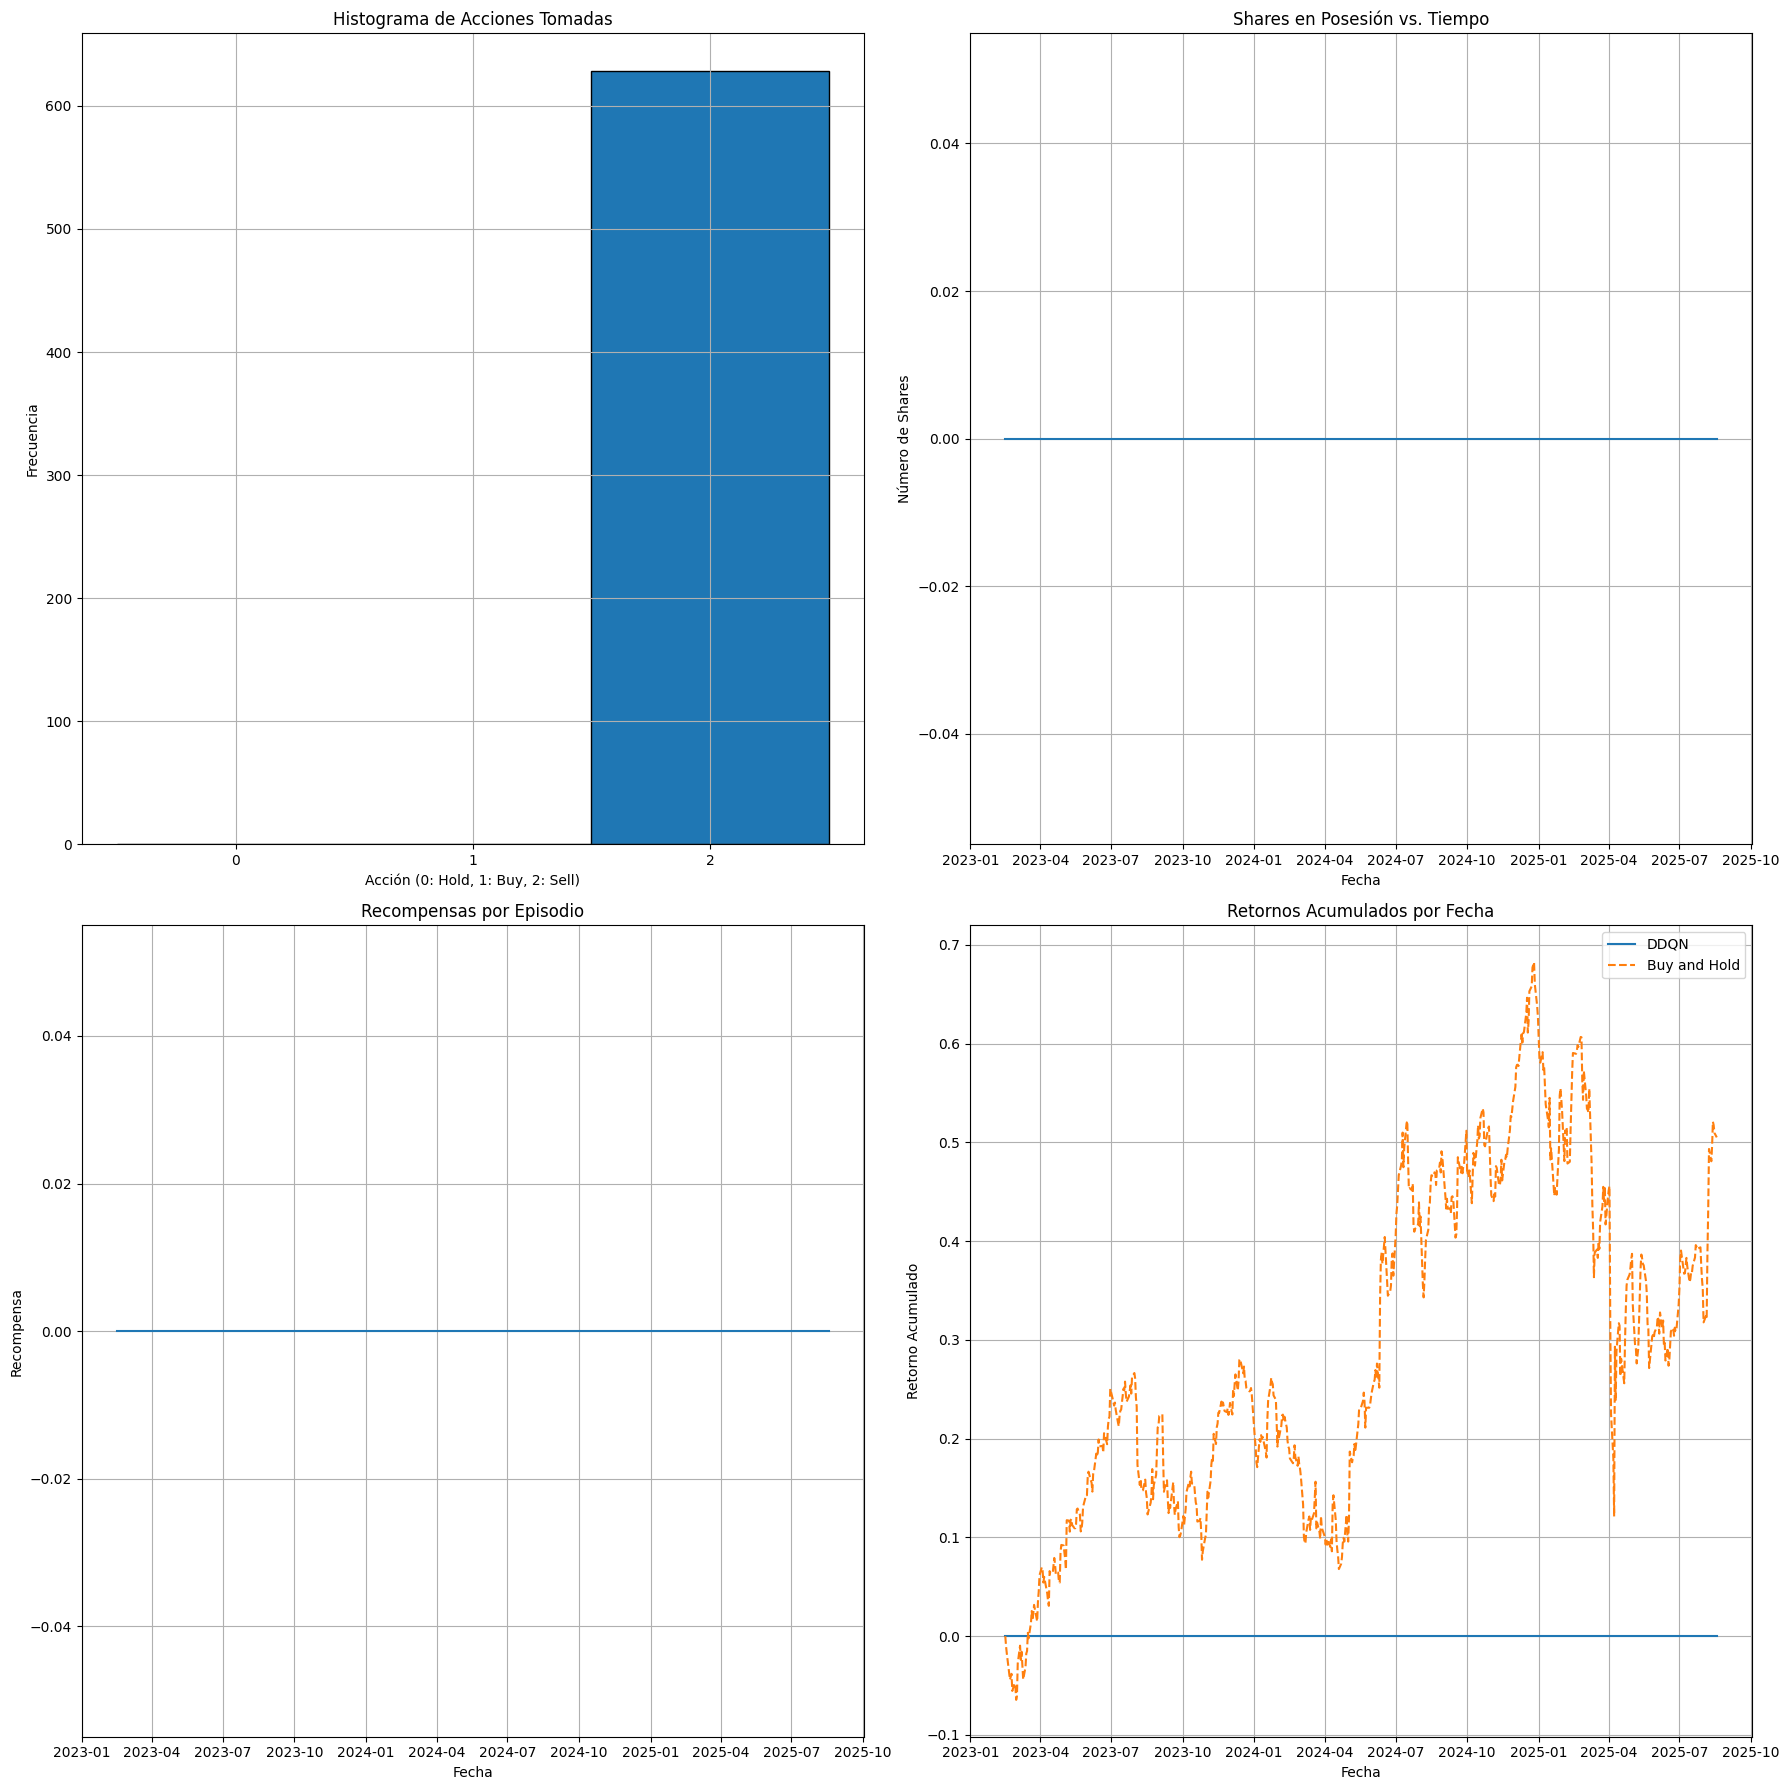

In [19]:
test_results = eval_agent(test_data)

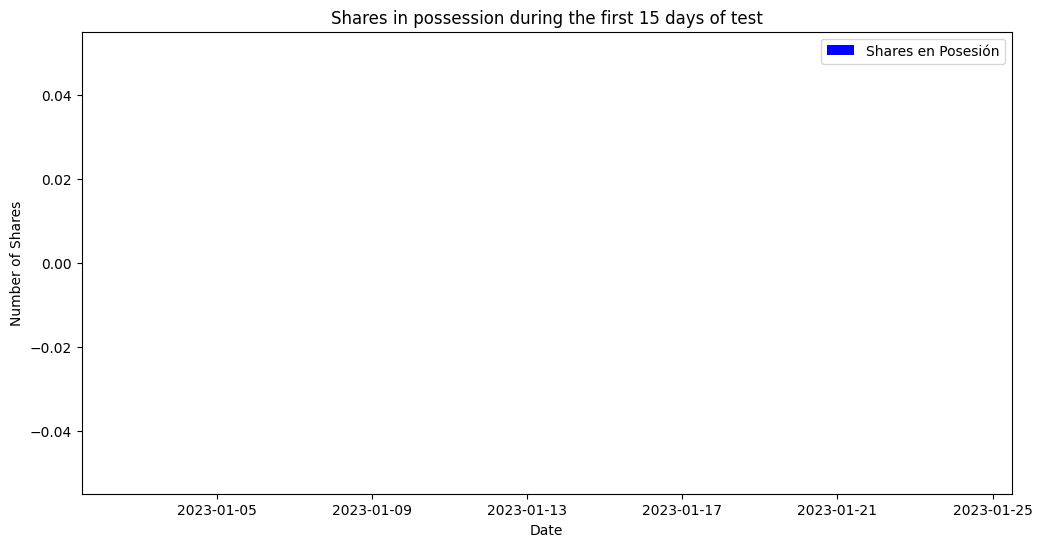

In [14]:
ndays = 15

plt.figure(figsize=(12, 6))
plt.bar(test_data.index[:ndays], test_results[1][:ndays], label='Shares en Posesión', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Shares')
plt.title(f'Shares in possession during the first {ndays} days of test')
plt.legend()
plt.show()